In [1]:
import numpy as np
from pathlib import Path
import struct
import matplotlib.pyplot as plt
import copy
from tqdm import tqdm
import time

In [2]:
dataset_path = Path("./MNIST")
train_img_path = dataset_path/'train-images-idx3-ubyte'
train_lab_path = dataset_path/'train-labels-idx1-ubyte'
test_img_path = dataset_path/'t10k-images-idx3-ubyte'
test_lab_path = dataset_path/'t10k-labels-idx1-ubyte'

In [3]:
with open(train_img_path, "rb") as f:
    struct.unpack(">4i", f.read(16))
    tmp_img = np.fromfile(f, dtype=np.uint8).reshape(-1, 28*28)/255
    train_img = tmp_img[:]
with open(test_img_path, "rb") as f:
    struct.unpack(">4i", f.read(16))
    test_img = np.fromfile(f, dtype=np.uint8).reshape(-1, 28*28)/255
with open(train_lab_path, "rb") as f:
    struct.unpack(">2i", f.read(8))
    tmp_lab = np.fromfile(f, dtype=np.uint8).reshape(-1, 1)
    train_lab = tmp_lab[:]
with open(test_lab_path, "rb") as f:
    struct.unpack(">2i", f.read(8))
    test_lab = np.fromfile(f, dtype=np.uint8).reshape(-1, 1)

In [4]:
# Function: show_img(index)
def show_img(img, label, index):
    plt.imshow(img[index].reshape(28,28), cmap='gray')
    # plt.pause()
    print(f"img label:{label[index]}")
    return None
# show_img(train_img, train_lab, 100)

In [5]:
train_num = train_img.shape[0]
test_num = test_img.shape[0]
# print(train_img.shape)
# print(test_img.shape)
# print(train_lab.shape)
# train_lab

[    7    10    12 ... 59978 59980 59996]
train set shape: (784, 60000)
train lab shape: (1, 60000)
test set shape: (784, 10000)
test lab shape: (1, 10000)


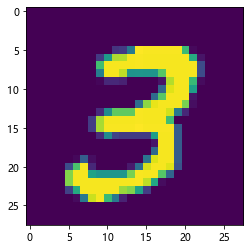

In [6]:
# 将给定num的label改为1
def train_setY(num):
    label = train_lab.copy()
    label[np.where(label != num)] = 10
    label[np.where(label == num)] = 1
    label[np.where(label == 10)] = 0
    return label
def test_setY(num):
    label = test_lab.copy()
    label[np.where(label != num)] = 10
    label[np.where(label == num)] = 1
    label[np.where(label == 10)] = 0
    return label

reg_num = 3
train_X = train_img.copy().T
train_Y = train_setY(reg_num).T
index_regnum = np.where(train_Y==1)
print(index_regnum[1])
test_X = test_img.copy().T
test_Y = test_setY(reg_num).T
print(f"train set shape: {train_X.shape}")
print(f"train lab shape: {train_Y.shape}")
print(f"test set shape: {test_X.shape}")
print(f"test lab shape: {test_Y.shape}")

# 存储原始数字矩阵
hw0 = train_X.T
i = index_regnum[1][0]
# np.save(f'handwritten{reg_num}.npy', hw0[i])
plt.imshow(hw0[i].reshape((28,28)))
plt.show()

In [7]:
# 激活函数
def sigmoid(z):
    s = 1.0 / (1.0 + np.exp(-1.0*z))
    return s
# 参数初始化
def initialize_with_zeros(seed, dim):
    np.random.seed(seed)
    w = np.random.random((dim, 1)) * np.sqrt(1/dim)
    # w = np.zeros((dim, 1))
    b = 0
    
    assert(w.shape == (dim, 1))
    assert(isinstance(b, float) or isinstance(b, int))
    
    return w, b

# 向前传播
def propagate(w, b, X, Y):
    m = X.shape[1]
    
    A = sigmoid(np.dot(w.T, X) + b)
    cost = -(1.0/m) * np.sum(Y * np.log(A) + (1-Y) * np.log(1-A))
    
    dw = (1.0/m) * np.dot(X, (A-Y).T)
    db = (1.0/m) * np.sum(A-Y)
    assert(dw.shape == w.shape)
    assert(db.dtype == float)

    Y_prediction = np.zeros((1, m))
    for i in range(A.shape[1]):
        if A[0, i] > 0.5:
            Y_prediction[0, i] = 1
        else:
            Y_prediction[0, i] = 0
    accu = 100 - np.mean(np.abs(Y_prediction-Y)) * 100
    
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    grads = {
        "dw": dw,
        "db": db
    }
    
    return grads, cost, accu

# 参数优化
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost=False):
    costs = []
    accus = []
    for i in range(num_iterations):
        grads, cost, accu = propagate(w, b, X, Y)
        dw = grads["dw"]
        db = grads["db"]
        
        w = w - learning_rate * dw
        b = b - learning_rate * db

        costs.append(cost)
        accus.append(accu)

        if print_cost and i%(num_iterations//10) == 0:
            print("Cost after iterations %i: %f" %(i, cost), end=' ')
            print(f"accu: {accus[-1]}%")
        
    params = {
        "w": w,
        "b": b
    }
    grads = {
        "dw": dw,
        "db": db
    }

    return params, grads, accus, costs

# 模型预测
def predict(w, b, X):
    m = X.shape[1]
    Y_prediction = np.zeros((1, m))
    w = w.reshape(X.shape[0], 1)
    
    A = sigmoid(np.dot(w.T, X) + b)
    
    for i in range(A.shape[1]):
        if A[0, i] > 0.5:
            Y_prediction[0, i] = 1
        else:
            Y_prediction[0, i] = 0
    assert(Y_prediction.shape == (1, m))
    
    return Y_prediction

In [8]:
# 组装模型
def model(X_train, Y_train, X_test, Y_test, num_iterations, learning_rate, seed, print_cost=False):
    w, b = initialize_with_zeros(seed, X_train.shape[0])
    parameters, grads, accus, costs= optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
    
    w = parameters["w"]
    b = parameters["b"]
    
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)
    
    print("train accuracy: {}%".format(100-np.mean(np.abs(Y_prediction_train-Y_train))*100))
    print("test accuracy: {}%".format(100-np.mean(np.abs(Y_prediction_test-Y_test))*100))
    
    d = {
        "accus": accus,
        "costs": costs,
        "Y_prediction_test": Y_prediction_test,
        "Y_prediction_train": Y_prediction_train,
        "w": w,
        "b": b,
        "learning_rate": learning_rate,
        "num_iterations": num_iterations
    }
    
    return d

In [9]:
print(f"Number {reg_num} Recognition:")
d = model(train_X, train_Y, test_X, test_Y, seed=6, num_iterations=1000, learning_rate=1, print_cost=True)

Number 3 Recognition:
Cost after iterations 0: 1.814720 accu: 10.218333333333334%
Cost after iterations 100: 0.099829 accu: 96.94333333333333%
Cost after iterations 200: 0.092783 accu: 97.21%
Cost after iterations 300: 0.089237 accu: 97.34166666666667%
Cost after iterations 400: 0.087007 accu: 97.42%
Cost after iterations 500: 0.085457 accu: 97.47166666666666%
Cost after iterations 600: 0.084315 accu: 97.50166666666667%
Cost after iterations 700: 0.083440 accu: 97.515%
Cost after iterations 800: 0.082750 accu: 97.545%
Cost after iterations 900: 0.082191 accu: 97.56166666666667%
train accuracy: 97.58333333333333%
test accuracy: 97.78%


In [10]:
accus = d['accus'].copy()
costs = d["costs"].copy()
w = d["w"].copy()

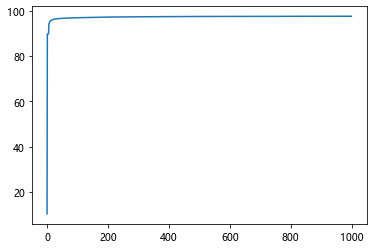

In [11]:
# accu&loss图像
plt.plot(accus)
plt.show()

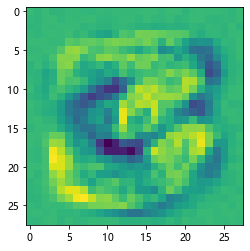

[0.41451783] [-0.76688401]


In [12]:
# w的可视化
plt.imshow(w.reshape((28, 28)))
plt.show()
print(max(w), min(w))